In [2]:
import argparse
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from visualise_layer_sparsity import visualise_layer



def visualise_network(sparsity_data = None):

    data_spec = "_".join(sparsity_data.split("/")[-1].split("_")[:-7])
    output_dir = os.path.join("figures", data_spec)
    mean_list = glob.glob(os.path.join(sparsity_data, "*_mean.npy"))
    corr_list = glob.glob(os.path.join(sparsity_data, "*_correlation.npy"))
    hist_list = glob.glob(os.path.join(sparsity_data, "*_histograms.npy"))
    data_list = zip(corr_list, hist_list)

    if not os.path.isdir(output_dir):
         os.makedirs(output_dir)

    output_path = os.path.join(output_dir, "layer_level_overview.png")

    network_overview(mean_list, corr_list, hist_list, data_spec, output_path)

    for corr_file, hist_file in data_list:
        output_path = os.path.join(output_dir, corr_file.split("/")[-1][:-16] + ".png")
        corr_data = np.load(corr_file)
        hist_data = np.load(hist_file)
        visualise_layer(corr_data, hist_data, output_path)


def network_overview(mean_list, corr_list, hist_list, data_spec, output_path):
    def plot_mean_per_layer(mean_data, layer_names, ax):
        ax.bar(layer_names, mean_data)
        ax.set_title("Average mean sparsity per layer")
        ax.set(xlabel = "Layer name", ylabel = "Average Sparsity")
    def plot_corr_per_layer(corr_data, layer_names, ax):
        ax.bar(layer_names, corr_data)
        ax.set_title("Average apRSITY correlation per layer")
        ax.set(xlabel = "Layer name", ylabel = "Average Correlation")
    def plot_non_zeros_per_layer(data, layer_names, ax):
        data[data == np.inf] = 0
        data[data == np.nan] = 0
        ax.bar(layer_names, data)
        ax.set_title("Average percentage of full zero windows per layer")
        ax.set(xlabel = "Layer name", ylabel = "Zero windows (%)")

    mean_layers = np.empty(len(mean_list))
    corr_layers = np.empty(len(corr_list))
    percentage_non_zeros_per_layer = np.empty(len(hist_list))
    layer_names = []
    for index, (mean_file, corr_file, hist_file) in enumerate(zip(mean_list, corr_list, hist_list)):

        mean_data = np.load(mean_file)
        corr_data = np.load(corr_file)
        hist_data = np.load(hist_file)
        corr_data[np.abs(corr_data) == np.Inf] = 1
        corr_data[np.abs(corr_data) == np.NaN] = 0
        mean_layers[index] = mean_data.mean()/(len(hist_data[0]) - 1)
        corr_layers[index] = corr_data.mean()
        hist_sum = hist_data.sum(axis = 0)
        percentage_non_zeros_per_layer[index] = hist_sum[-1]/hist_sum.sum()
        layer_names.append(corr_file.split("/")[-1].split("_")[1:-1][0])

    fig, ax = plt.subplots(3)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.suptitle('Overview of sparsity statistics for ' + data_spec)
    plot_mean_per_layer(mean_layers, layer_names, ax[0])
    plot_corr_per_layer(corr_layers, layer_names, ax[1])
    plot_non_zeros_per_layer(percentage_non_zeros_per_layer, layer_names, ax[2])
    print("Saving in output path", output_path)
    fig.savefig(output_path)



if __name__ == "__main__":
    sparsity_data = "../runlog/resnet18_sparsity_run_50K_relu_0.01_2023_04_05_13_22_12_846615"
    data_spec = "_".join(sparsity_data.split("/")[-1].split("_")[:-7])
    output_dir = os.path.join("figures", data_spec)
    mean_list = glob.glob(os.path.join(sparsity_data, "*_mean.npy"))
    corr_list = glob.glob(os.path.join(sparsity_data, "*_correlation.npy"))
    hist_list = glob.glob(os.path.join(sparsity_data, "*_histograms.npy"))
    data_list = zip(corr_list, hist_list)

    if not os.path.isdir(output_dir):
         os.makedirs(output_dir)

    output_path = os.path.join(output_dir, "layer_level_overview.png")

    network_overview(mean_list, corr_list, hist_list, data_spec, output_path)

ModuleNotFoundError: No module named 'seaborn'

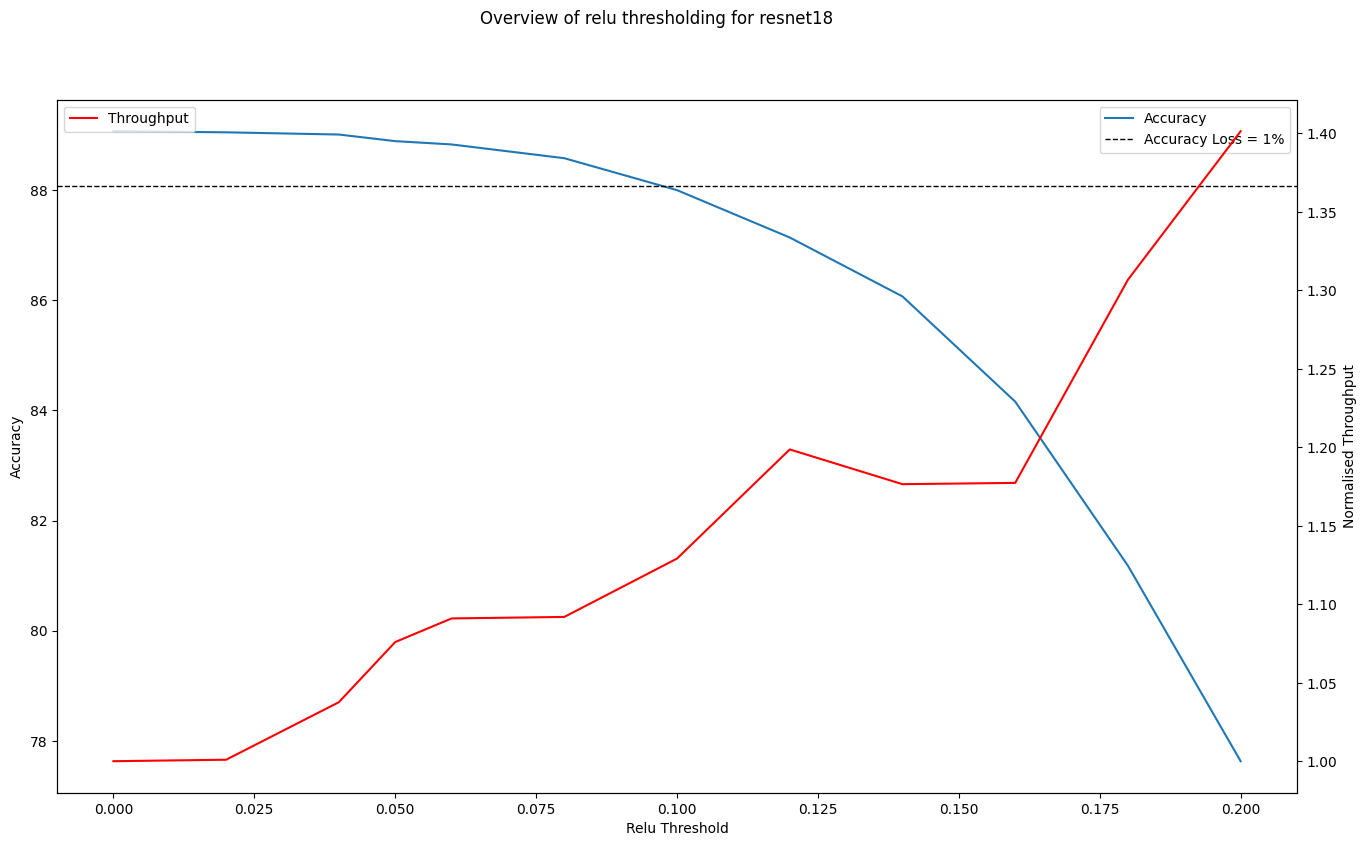

In [8]:
import pandas as pd

data = pd.read_csv("../runlog/resnet18_accuracy_var_relu.csv")

fig, ax1 = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(16)
ax2 = ax1.twinx()

ax1.plot(data["ReLU_Threshold"], data["Top5_Accuracy"], label="Accuracy")
ax1.axhline(data["Top5_Accuracy"].max() - 1, color='k', linestyle='dashed', linewidth=1, label="Accuracy Loss = 1%")
ax2.plot(data["ReLU_Threshold"], data["Throughput"]/(data["Throughput"].min()), label="Throughput", color = 'r')


fig.suptitle('Overview of relu thresholding for resnet18')
ax1.set(xlabel = "Relu Threshold", ylabel = "Accuracy")
ax2.set(xlabel = "Relu Threshold", ylabel = "Normalised Throughput")
ax1.legend(loc = "best")
ax2.legend(loc = "best")

fig.savefig("figures/resnet18_relu_acc_vs_through.png")
